#Robust Spectrotemporal Decomposition by Iteratively Reweighted Least Squares

Contributed by: Armen Gharibans

Reference: Ba, D., Babadi, B., Purdon, P. L., & Brown, E. N. (2014). Robust spectrotemporal decomposition by iteratively reweighted least squares. Proceedings of the National Academy of Sciences, 111(50), E5336-E5345.	

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import scipy as sp
%matplotlib inline

## Toy Example

This example points out the limitations of classical techniques in analyzing time series data.  We simulated noisy observations from the linear combination of two amplitude-modulated signals using the following equation:

$y_{t}=10 \cos^{8}\left(2\pi f_{o}t\right) \sin\left(2\pi f_{1}t\right)+10\exp\left(4\frac{t-T}{T}\right)\cos\left(2\pi f_{2}t\right)+v_{t}, \quad$ for $\enspace 0\leq t \leq T$

where $f_{0}=0.04$ Hz, $f_{1}=10$ Hz, $f_{2}=11$ Hz, $T=600$ s, and $\left(v_{t}\right)_{t=1}^{T}$ is independent, identically distributed, zero-mean Gaussian noise with variance set to acheive a signal-to-noise ratio (SNR) of 5 dB.

The simulated data consists of a 10 Hz oscillation whos amplitude is modulated by  slow 0.04 Hz oscillation, and an exponentially gorwing 11 Hz oscillation.


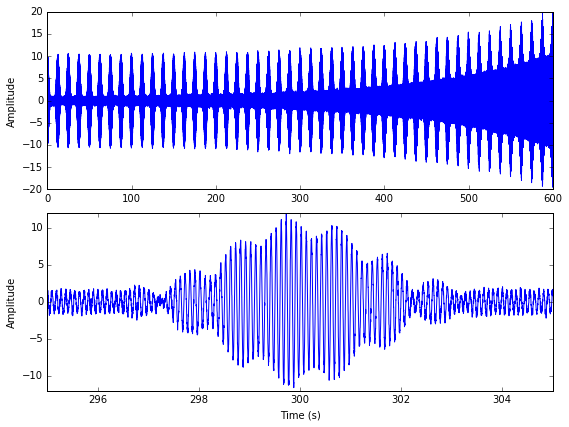

In [5]:
T  = 600   #[s]
fs = 500   #[Hz]
f0 = 0.04  #[Hz]
f1 = 10    #[Hz]
f2 = 11    #[Hz]

t = np.linspace(0,T,fs*T)
signal = 10*(np.cos(2*np.pi*f0*t))**8*np.sin(2*np.pi*f1*t) + \
         10*np.exp(4*(t-T)/T)*np.cos(2*np.pi*f2*t)
noise = np.random.normal(0,0.3,T*fs)

signal = signal + noise

#PLOT
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(8,6))

ax[0].plot(t,signal)
ax[0].set_ylabel('Amplitude')

ax[1].plot(t,signal)
ax[1].set_ylabel('Amplitude')
ax[1].set_xlabel('Time (s)')
ax[1].set_xlim([295,305])
ax[1].set_ylim([-12,12])
fig.tight_layout()

The following is a spectrogram of the simulated signal that highlights the limitations of classical frequency analysis.  The analysis is unable to resolve the closely spaced signals of 10 and 11 Hz in the frequency domain.

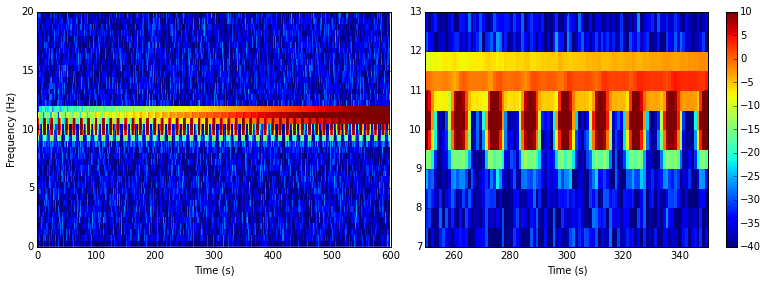

In [13]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(11,4))

im1 = ax[0].specgram(signal,NFFT=1000,Fs=500,noverlap=500,interpolation='none')
ax[0].set_ylim([0,20])
ax[0].set_ylabel('Frequency (Hz)')
ax[0].set_xlabel('Time (s)')
im1[3].set_clim(-40,10)

im2 = ax[1].specgram(signal,NFFT=1000,Fs=500,noverlap=500,interpolation='none')
ax[1].set_xlim([250,350])
ax[1].set_ylim([7,13])
ax[1].set_xlabel('Time (s)')
fig.tight_layout()
im2[3].set_clim(-40,10)
cb = fig.colorbar(im2[3])

## Robust Spectral Decomposition

### The State-Space Model

In this analysis, we will consider a signal $y_{t}$ that is obtained by sampling a noisy, continuous-time signal at rate $f_{s}$ (above the Nyquist rate).

* $y_{t}\rightarrow$ discrete-time signal
* $t = 1,2,...,T\rightarrow$ samples
* $f_{s}\rightarrow$ sampling rate
* $W\rightarrow$ arbitrary window length
* $N \triangleq \frac{T}{W}\rightarrow$ number of windows
* $y_{n} \triangleq \left(y_{\left(n-1\right)W+1},y_{\left(n-1\right)W+2},...,y_{nW}\right)'$ for $n=1,2,...,N$

Consider the following spectrotemporal representation of $y_{n}$ as:

$$y_{n} = \tilde{F}_{n}\tilde{x}_{n} + v_{n}$$
where,
* $\left ( \tilde{F}_{n} \right )_{l,k} \triangleq \exp \left( j2\pi \left( \left(n-1 \right) W+l \right) \frac{\left( k-1 \right)}{K} \right)$
for $l=1,2,...,W$ and $k=1,2,...K$
* $\tilde{x}_{n} \triangleq \left(\tilde{x}_{n,1},\tilde{x}_{n,2},...,\tilde{x}_{n,K} \right)' $
* $v_{n}\rightarrow$ independent, identically distributed, additive zero-mean Gaussian noise

Equivalently, we can define the linear observation model over a real vector space as follows:

$$y_{n} = F_{n}x_{n}+v_{n}$$
where,
* $\left ( F_{n} \right )_{l,k} \triangleq \cos \left( 2\pi \left( \left(n-1 \right) W+l \right) \frac{\left( k-1 \right)}{K} \right)$ for $l = 1,2,...,W$ and $k=1,2,...\frac{K}{2}$
* $\left ( F_{n} \right )_{l,k+K/2} \triangleq \sin \left( 2\pi \left( \left(n-1 \right) W+l \right) \frac{\left( k-1 \right)}{K} \right)$ for $l = 1,2,...,W$ and $k=1,2,...\frac{K}{2}$
* $x_{n} \triangleq \left(x_{n,1},x_{n,2},...,x_{n,K} \right)' $

In [12]:
# Define Matrix F

numSamples = fs*T  #num samples
W = 1000           #window size
K = W              #frequency bands
N = numSamples//W  #number of windows

F = np.zeros([W,K])
k = np.array(range(1,K//2+1))
l = np.array(range(1,W+1))

for jj in range(0,np.size(k)):
    for ii in range(0,np.size(l)):                      
        F[ii,jj]      = np.cos(2*np.pi*l[ii]*(k[jj]-1)/K)
        F[ii,jj+K//2] = np.sin(2*np.pi*l[ii]*(k[jj]-1)/K)

#plt.imshow(F)
#print(np.shape(F))

The objective is to compute an estimate $\hat{x}$ of $x$ given the data $y$.  The component-wise magnitude-squared of $\hat{x}$ gives an estimate of the magnitude spectrum of $y$.  By treating $\left(x_{n}\right)_{n=1}^{N}$ as a sequence of random variables and carefully selecting a prior distribution, a stochastic continuity constraint can be established across time.  By imposing a model on the components $\left(x_{n,k}\right)_{k=1}^{K}$ for each $n = 1,2,..,N$, sparsity is enforced in the frequency domain.  The stochastic continuity constraint can be expressed in the form of the first-order difference equation:

$$x_{n} = x_{n-1} + w_{n}$$
where $w = \left( w_{1}',w_{2}',...,w_{N}'\right)'$ is a random vector.  The following joint prior probability density function is used to enforce sparsity in the frequency domain and smoothness in time:
$$\log p_{1}\left(w_{1},w_{2},...,w_{N}\right) = -\alpha \sum_{k=1}^{K} \left( \sum_{n=1}^{N} w_{n,k}^{2} + \epsilon^{2} \right)^\frac{1}{2}+c_{1}$$
where $\alpha > 0$ is a constant and $\epsilon > 0$ is a small constant.

### The Inverse Solution

Bayesian estimation is used to compute the robust spectral decomposition of $y$, where the posterior density of $x$ given $y$ fully characterizes the space of inverse solutions.  This is computed by solving the following MAP estimation problem:

$$\max_{x_{1},...x_{N}} -\sum_{n=1}^{N} \frac{1}{2\sigma^{2}} \left \| y_{n} - F_{n}x_{n} \right \|^{2}_{2} + f\left(x_{1},x_{2},...,x_{N}\right)$$

where $f\left(x_{1},x_{2},...,x_{N}\right) \triangleq \log p_{i} \left(x_{1}-x_{0},x_{2}-x_{1},...,x_{N}-x_{N-1}\right)$.  This is a strictly concave optimization problem that can be solved using standard techniques.  However, these techniques do not scale well with $N$ becuase of the batch nature of the problem.

### Kalman Filter
The Kalman filter solves the least-squares estimation problem recursively, and in a computationally efficient manner.  The algorithm works in a two-step process.  In the prediciton step, the Kalman filter produces estimates of the current state variables, along with their uncertainties.  Once the outcome of the next measurement (corrupted with some amount of error, including random noise) is observed, these estimates are updated with  more weight being given to estimates with higher certainty.

<img src="http://i.imgur.com/s1YU6Qy.png">

**Algorithm:**

Initial Conditions: 

* $x_{0\mid 0} = \left(0,...,0\right)' \in \mathbb{R}^{K}$
* $\Sigma_{0\mid 0} = I_{k} \in \mathbb{R}^{KK}$

Filter at time $n=1,2,...,N$:
* $x_{n\mid n-1}=x_{n-1 \mid n-1}$
* $\Sigma_{n\mid n-1}=\Sigma_{n-1\mid n-1}+Q^{\left(l\right)}$
* $K_{n}=\Sigma_{n\mid n-1}F_{n}^{H}\left(F_{n}\Sigma_{n\mid n-1}F_{n}^{H}+\sigma^{2}I\right)^{-1}$
* $x_{n\mid n}=x_{n\mid n-1}+K_{n}\left(y_{n}-F_{n}x_{n\mid n-1}\right)$
* $\Sigma_{n\mid n}=\Sigma_{n\mid n-1}-K_{n}F_{n}\Sigma_{n\mid n-1}$

In [15]:
#initialize
Q = np.eye(K)*0.001
xKalman = np.zeros([K,N+1])
xPredict = np.zeros([K,N+1])
sigKalman = np.zeros([K,K,N+1])
sigPredict = np.zeros([K,K,N+1])
sigKalman[:,:,0] = np.eye(K)

#Kalman Filter
for n in range(0,N):
    y = signal[n*W:(n+1)*W]
    xPredict[:,n+1] = xKalman[:,n]
    sigPredict[:,:,n+1] = sigKalman[:,:,n] + Q
    gainK = np.dot(sigPredict[:,:,n+1],F.T).dot(np.linalg.inv(np.dot(F,sigPredict[:,:,n+1]).dot(F.T)+np.eye(K)))
    xKalman[:,n+1] = xPredict[:,n+1] + np.dot(gainK,y-np.dot(F,xPredict[:,n+1]))
    sigKalman[:,:,n+1] = sigPredict[:,:,n+1] - np.dot(gainK,F).dot(sigPredict[:,:,n+1])

#remove initial conditions
xKalman = xKalman[:,1:N+1]
xPredict = xPredict[:,1:N+1]
sigKalman = sigKalman[:,:,1:N+1]
sigPredict = sigPredict[:,:,1:N+1]

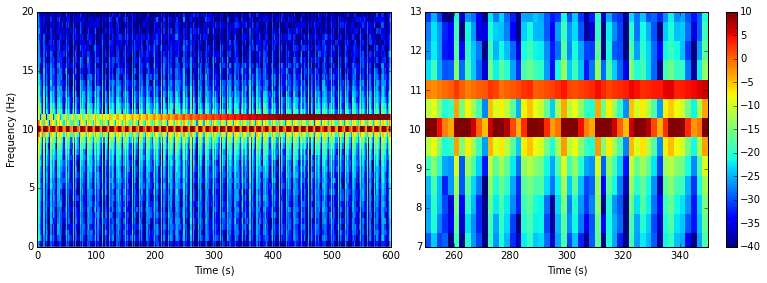

In [16]:
xEst = xKalman[0:K//2,:]-xKalman[K//2:W,:]*1j
xPSD = 10*np.log10(np.abs(xEst)**2)

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(11,4))

im1 = ax[0].imshow(xPSD,origin='lower',extent=[0,N*W//fs,0,fs//2-5],aspect='auto',interpolation='none')
ax[0].set_ylim([0,20])
ax[0].set_ylabel('Frequency (Hz)')
ax[0].set_xlabel('Time (s)')
im1.set_clim(-40,10)

im2 = ax[1].imshow(xPSD,origin='lower',extent=[0,N*W//fs,0,fs//2-5],aspect='auto',interpolation='none')
ax[1].set_xlim([250,350])
ax[1].set_ylim([7,13])
ax[1].set_xlabel('Time (s)')
fig.tight_layout()
im2.set_clim(-40,10)
cb = fig.colorbar(im2)

### Kalman Smoother

The Kalman filter is designed for real-time applications.  It estimates the properties of a system at a given time using measurments of the system up to that time.  However, when a real-time estimate is not needed, the Kalman filter effectively throws away half of the measurement data.  The Kalman smoother is an extension of the Kalman filter that uses measurement information from after the time at which state estimates are required as well as before that time.

**Algorithm**

Smoother at time $n=N-1,N-2,...,1:$

* $B_{n}=\Sigma_{n\mid n}\Sigma_{n+1\mid n}^{-1}$
* $x_{n\mid N}=x_{n\mid n}+B_{n}\left(x_{n+1\mid N}-x_{n+1\mid n}\right)$
* $\Sigma_{n\mid N}=\Sigma_{n\mid n}+B_{n}\left(\Sigma_{n+1\mid N}-\Sigma_{n+1\mid n}\right)B_{n}^{H}$

In [7]:
xSmooth = xKalman
sigSmooth = sigKalman

for n in range(N-2,-1,-1):
    B = np.dot(sigKalman[:,:,n],np.linalg.inv(sigPredict[:,:,n+1]))
    xSmooth[:,n] = xKalman[:,n] + np.dot(B,(xSmooth[:,n+1]-xPredict[:,n+1]))
    sigSmooth[:,:,n] = sigKalman[:,:,n] + np.dot(B,(sigSmooth[:,:,n+1]-sigPredict[:,:,n+1])).dot(B.T)

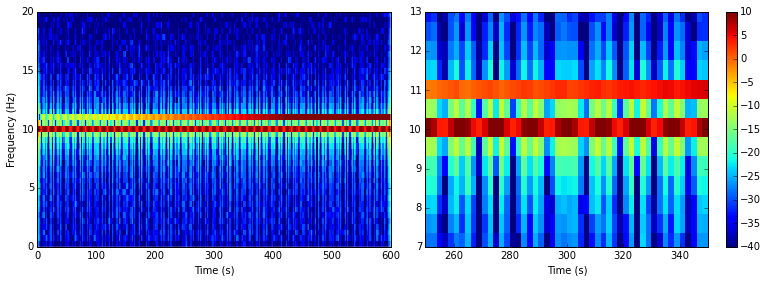

In [9]:
xEst = xSmooth[0:K//2,:]-xSmooth[K//2:W,:]*1j
xPSD = 10*np.log10(np.abs(xEst)**2)

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(11,4))

im1 = ax[0].imshow(xPSD,origin='lower',extent=[0,N*W//fs,0,fs//2-5],aspect='auto',interpolation='none')
ax[0].set_ylim([0,20])
ax[0].set_ylabel('Frequency (Hz)')
ax[0].set_xlabel('Time (s)')
im1.set_clim(-40,10)

im2 = ax[1].imshow(xPSD,origin='lower',extent=[0,N*W//fs,0,fs//2-5],aspect='auto',interpolation='none')
ax[1].set_xlim([250,350])
ax[1].set_ylim([7,13])
ax[1].set_xlabel('Time (s)')
fig.tight_layout()
im2.set_clim(-40,10)
cb = fig.colorbar(im2)

### IRLS Algorithm for Spectrotemporal Pursuit

The solution to the optimization problem can be obtained as the limit of a sequence $\left(\hat{x}^\left(l\right)\right)_{l=0}^{\infty}$ whose $l^{th}$ element is the solution to the Guassian MAP estimation problem (constrained least-squares program) of the form:

$$ \max_{x_{1},...,x{N}} -\sum_{n=1}^{N} \frac{1}{2\sigma^{2}} \left \| y_{n} - F_{n}x_{n} \right \|^{2}_{2} - \sum_{k=1}^{K} \sum_{n=1}^{N} \frac{\left(x_{n,k}-x_{n-1,k}\right)^{2}}{2\left(Q^{\left(l\right)}\right)_{k,k}}  $$

where,
$$ \left(Q^{\left(l\right)}\right)_{k,k} = \frac{\left(\sum_{n=1}^{N}\left(\hat{x}_{n,k}^{\left(l-1\right)}-\hat{x}_{n-1,k}^{\left(l-1\right)} \right)+\epsilon^{2}\right)^{\frac{1}{2}}}{\alpha} \rightarrow K\times K \textrm{ diagonal matrix}$$

This is a quadratic program with strictly concave objective function and block-tridiagonal Hessian. It can be solved iteratively using the following steps:

** Input: **
* $y \rightarrow$ observations
* $\hat{x}^{\left(0\right)} \in \mathbb{R}^{KN}\rightarrow$ initial guess
* $Q^{\left(0\right)} \rightarrow$ initial state-noise covariance
* $x_{0\mid0}, \Sigma_{0\mid0} \rightarrow$ intial conditions
* $tol \in \left(0,0.01\right) \rightarrow$ tolerance
* $L_{max} \in \mathbb{N}^{+} \rightarrow$ maximum number of iterations

**Step 0.** Initialize iteration number $l$ to 1

**Step 1.** Kalman Filter at time $n=1,2,...,N$:

* $x_{n\mid n-1}=x_{n-1 \mid n-1}$
* $\Sigma_{n\mid n-1}=\Sigma_{n-1\mid n-1}+Q^{\left(l\right)}$
* $K_{n}=\Sigma_{n\mid n-1}F_{n}^{H}\left(F_{n}\Sigma_{n\mid n-1}F_{n}^{H}+\sigma^{2}I\right)^{-1}$
* $x_{n\mid n}=x_{n\mid n-1}+K_{n}\left(y_{n}-F_{n}x_{n\mid n-1}\right)$
* $\Sigma_{n\mid n}=\Sigma_{n\mid n-1}-K_{n}F_{n}\Sigma_{n\mid n-1}$

**Step 2.** Smoother at time $n=N-1,N-2,...,1$:

* $B_{n}=\Sigma_{n\mid n}\Sigma_{n+1\mid n}^{-1}$
* $x_{n\mid N}=x_{n\mid n}+B_{n}\left(x_{n+1\mid N}-x_{n+1\mid n}\right)$
* $\Sigma_{n\mid N}=\Sigma_{n\mid n}+B_{n}\left(\Sigma_{n+1\mid N}-\Sigma_{n+1\mid n}\right)B_{n}^{H}$

**Step3.** Let $\hat{x}_{n}^{\left(l\right)}=x_{n\mid N},n=1,...,N$ and $\hat{x}^{\left(l\right)}=\left(\hat{x}_{1}^{\left(l\right)'},...,\hat{x}_{N}^{\left(l\right)'}\right)'$

**Step4.** Stop if $\frac{\left \| \hat{x}^{\left(l \right )}-\hat{x}^{\left(l-1 \right) } \right \|_{2}}{\left \| \hat{x}^{\left(l-1 \right) }\right \|_{2}}<tol$ or $l=L_{max}$

**Step5.** Let $l=l+1$, and update the state covariance $Q_n^{\left(l\right)}$

**Step6.** Go back to Step 1

** Output:** $\hat{x}^{\left(L\right)}$, where $L\leq L_{max}$ is the number of the last iteration of the algorithm


In [10]:
#Parameters
alpha = 21000
tol = 0.005
maxIter = 10

Q = np.eye(K)*0.001
iter = 1

while (iter <= maxIter):    
    #Step 1:
    #initialize
    xKalman = np.zeros([K,N+1])
    xPredict = np.zeros([K,N+1])
    sigKalman = np.zeros([K,K,N+1])
    sigPredict = np.zeros([K,K,N+1])
    sigKalman[:,:,0] = np.eye(K)

    #Kalman Filter
    for n in range(0,N):
        y = signal[n*W:(n+1)*W]
        xPredict[:,n+1] = xKalman[:,n]
        sigPredict[:,:,n+1] = sigKalman[:,:,n] + Q
        gainK = np.dot(sigPredict[:,:,n+1],F.T).dot(np.linalg.inv(np.dot(F,sigPredict[:,:,n+1]).dot(F.T)+np.eye(K)))
        xKalman[:,n+1] = xPredict[:,n+1] + np.dot(gainK,y-np.dot(F,xPredict[:,n+1]))
        sigKalman[:,:,n+1] = sigPredict[:,:,n+1] - np.dot(gainK,F).dot(sigPredict[:,:,n+1])

    #remove initial conditions
    xKalman = xKalman[:,1:N+1]
    xPredict = xPredict[:,1:N+1]
    sigKalman = sigKalman[:,:,1:N+1]
    sigPredict = sigPredict[:,:,1:N+1]
    
    #Step 2:
    #initialize
    xSmooth = xKalman
    sigSmooth = sigKalman

    #Kalman Smoother
    for n in range(N-2,-1,-1):
        B = np.dot(sigKalman[:,:,n],np.linalg.inv(sigPredict[:,:,n+1]))
        xSmooth[:,n] = xKalman[:,n] + np.dot(B,(xSmooth[:,n+1]-xPredict[:,n+1]))
        sigSmooth[:,:,n] = sigKalman[:,:,n] + np.dot(B,(sigSmooth[:,:,n+1]-sigPredict[:,:,n+1])).dot(B.T)
    
    #Step 4:
    if iter > 1 and np.linalg.norm(xSmooth-xPrev,'fro')/np.linalg.norm(xPrev,'fro') < tol:
        break
    
    #Step 5: Update Q
    Q = np.zeros([K,K])
    for k in range(0,K):
        qTemp = 0
        for n in range(1,N):
            qTemp += (xSmooth[k,n]-xSmooth[k,n-1])**2
        Q[k,k] = (qTemp + np.finfo(float).eps**2)**(1/2)/alpha
    
    xPrev = xSmooth
    iter += 1
    
print(iter-1)

(1000, 301)
(1000, 301)
(1000, 301)
2


In [13]:
print fs

500


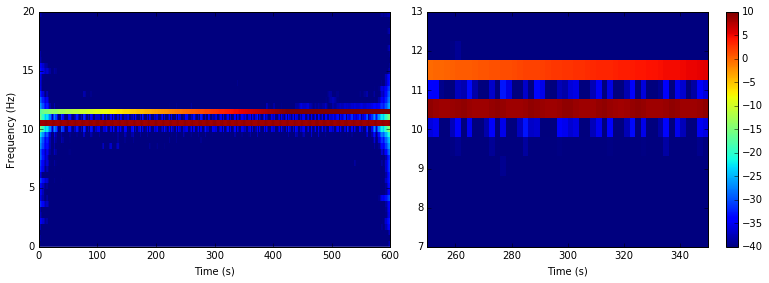

In [11]:
xEst = xSmooth[0:K//2,:]-xSmooth[K//2:W,:]*1j
xPSD = 10*np.log10(np.abs(xEst)**2)

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(11,4))

im1 = ax[0].imshow(xPSD,origin='lower',extent=[0,N*W//fs,0,fs//2-5],aspect='auto',interpolation='none')
ax[0].set_ylim([0,20])
ax[0].set_ylabel('Frequency (Hz)')
ax[0].set_xlabel('Time (s)')
im1.set_clim(-40,10)

im2 = ax[1].imshow(xPSD,origin='lower',extent=[0,N*W//fs,0,fs//2-5],aspect='auto',interpolation='none')
ax[1].set_xlim([250,350])
ax[1].set_ylim([7,13])
ax[1].set_xlabel('Time (s)')
fig.tight_layout()
im2.set_clim(-40,10)
cb = fig.colorbar(im2)

Spectrotemporal pursuit gives the sparse, more compact representation that better characterizes the equation simulated in this toy example.  We are able to recover the two frequencies (10 and 11 Hz) as well their temporal modulation.  The estimate is also significantly denoised relative to the STFT spectrogram.